<a href="https://colab.research.google.com/github/gn0262487838/DL_note/blob/master/Sentiment_by_LSTM_and_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
'''
data from https://inclass.kaggle.com/c/si650winter11
作為練習

'''
! pip install -U nltk
nltk.download("punkt")

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import collections

In [77]:
# parameter
VOCAB_SIZE = 2000 + 2
SENTENCE_MAX_LEN = 40
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 128
LABEL_SIZE = 1
LR = 0.001

# preprocessing : data
maxlen = 0
sentence_nums = 0
vocab = collections.Counter()
with open("./training.txt", "r", encoding="UTF-8") as f:
    for line in f:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())

        maxlen = len(words) if len(words) > maxlen else maxlen
            
        # freq word
        for word in words:
            if not word in vocab:
                vocab[word] = 1
            elif word in vocab:
                vocab[word] += 1
        sentence_nums += 1

word2num = { v[0]:k+2 for k, v in enumerate(vocab.most_common(VOCAB_SIZE if VOCAB_SIZE < len(vocab) else len(vocab)))}
word2num["pad"], word2num["unk"] = 0, 1
num2word = { k:v for v, k in word2num.items()}

print(f"最長句子的長度:{maxlen:}")
print(f"字典厚度:{len(vocab):}")
print(f"總共有幾句話:{sentence_nums:}")

最長句子的長度:42
字典厚度:2326
總共有幾句話:7086


In [0]:
import numpy as np
x_train = np.empty(sentence_nums, dtype=list)
y_train = np.empty(sentence_nums, dtype=int)

with open("./training.txt", "r", encoding="UTF-8") as f :
    idx = 0
    for line in f:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        
        # 轉換每一個句子成為數字
        seq = []
        for word in words:
            if word in word2num:
                seq.append(word2num[word])
            else:
                seq.append(word2num["unk"])
        x_train[idx] = seq
        y_train[idx] = int(label)
        idx += 1

# 補0
x_train = pad_sequences(x_train, maxlen=SENTENCE_MAX_LEN)

In [79]:
print("訓練資料長這樣:\n", x_train)
print("答案長這樣:\n", y_train)

訓練資料長這樣:
 [[  0   0   0 ...  48  22   4]
 [  0   0   0 ... 341  67   4]
 [  0   0   0 ...  18 325   4]
 ...
 [  0   0   0 ...  11  13   4]
 [  0   0   0 ... 127  26   4]
 [  0   0   0 ...  87  26   4]]
答案長這樣:
 [1 1 1 ... 0 0 0]


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2)


In [81]:
model = Sequential()
model.add(
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, input_length=SENTENCE_MAX_LEN)
)
model.add(
    LSTM(units=HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.1)
)
model.add(
    Dense(units=LABEL_SIZE, activation="sigmoid")
)
model.compile(
    optimizer = Adam(learning_rate=LR),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 256)           512512    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 709,761
Trainable params: 709,761
Non-trainable params: 0
_________________________________________________________________


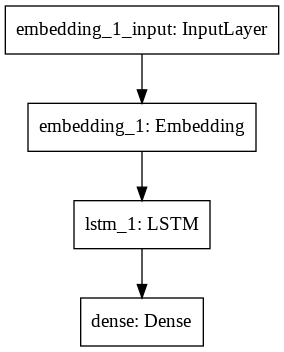

In [82]:
plot_model(model)

In [86]:
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint
model.fit(X_train, Y_train, batch_size=200, epochs=10, validation_data=(X_test, Y_test),
        callbacks=[
                EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, restore_best_weights=True),
                ModelCheckpoint("./", monitor="val_loss", mode="auto", save_weights_only=True)
        ]
        )

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 3s 574us/sample - loss: 0.4901 - acc: 0.7652 - val_loss: 0.2176 - val_acc: 0.9386
Epoch 2/10
5668/5668 [==============================] - 2s 334us/sample - loss: 0.1142 - acc: 0.9697 - val_loss: 0.0797 - val_acc: 0.9767
Epoch 3/10
5668/5668 [==============================] - 2s 333us/sample - loss: 0.0362 - acc: 0.9926 - val_loss: 0.0477 - val_acc: 0.9852
Epoch 4/10
5668/5668 [==============================] - 2s 348us/sample - loss: 0.0113 - acc: 0.9975 - val_loss: 0.0521 - val_acc: 0.9901
Epoch 5/10
5668/5668 [==============================] - 2s 335us/sample - loss: 0.0059 - acc: 0.9991 - val_loss: 0.0373 - val_acc: 0.9880
Epoch 6/10
5668/5668 [==============================] - 2s 335us/sample - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9859
Epoch 7/10
5668/5668 [==============================] - 2s 341us/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0611 - va

In [94]:
model.evaluate(x_train, y_train, batch_size=32)

7086/7086 [==============================] - 3s 470us/sample - loss: 0.0096 - acc: 0.9976


[0.009647301147709517, 0.9976009]